In [679]:
#housekeeping and essential imports
import pandas as pd
import os
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1200)
pd.set_option ('display.max_colwidth', 70)

In [680]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Step 1: read raw data files, filter, then save filtered data in tab delimited text file

### Step 2: Find reads that match to reference

Note: __do not run__ in jupyter. This script will run for 4 - 5 hours.

In [ ]:
# %load /Users/chao/GoogleDrive/NYU/interview/rerun_match/match.py
import pandas as pd
import os
import numpy as np
import gc

def main():
    
    # read in reference data, most importantly the start and end pos of known genes
    os.chdir(os.path.join(os.path.expanduser("~"),"GoogleDrive/NYU/interview/rerun_match/"))
    DIR = os.getcwd()
    ref = pd.read_csv(os.path.join(DIR, "UTR_filtered.txt"), sep="\t")

    # read F4175 cleaned data
    F4175 = pd.read_csv(os.path.join(DIR, "F4175_filtered.txt"), sep="\t")
    F4175 = F4175.drop(F4175[F4175.strand.isin(["+"])].index) # only use "-" strands
    F4175.reset_index(drop=True, inplace=True)

    # read F231 cleaned data
    F231 = pd.read_csv(os.path.join(DIR, "F231_filtered.txt"), sep="\t")
    F231 = F231.drop(F231[F231.strand.isin(["+"])].index) # only use "-" strands
    F231.reset_index(drop=True, inplace=True)

    def findMatch(read, refer=ref):
        """find reads that are inside of 3'UTR. Only use - strands"""
        target = []
        for s in read.itertuples():
            for row in ref.itertuples():
                if s[2] >= row[2] and s[2] <= row[3]:
                    target.append((s[0], s[2], s[3], s[4], row[0],row[2], row[3], row[4]))
        target = pd.DataFrame(target, columns=['read_index', 'read_start', 'read_end',  'read_id', 'ref_index','ref_start', 'ref_end', 'gene_id'])
        return target

    #sample is for testing
    #sample = F231.iloc[np.random.randint(0,len(F231), size=10)]
    #target_sample = findMatch(read=sample)
    #target_sample.to_csv(os.path.join(DIR, "sample_matched.txt"), sep="\t", header=True, index=False)
    print("Finished sample")
    
    #del([sample, target_sample])
    #gc.collect()
    
    # match F4175
    match_F4175 = findMatch(read=F4175)
    match_F4175.to_csv(os.path.join(DIR, "F4175_matched.txt"), sep="\t", header=True, index=False)
    print("Finished F4175")
    
    del([match_F4175, F4175])
    gc.collect()
    
    # match F231
    match_F231 = findMatch(read=F231)
    match_F231.to_csv(os.path.join(DIR, "F231_matched.txt"), sep="\t", header=True, index=False)
    print("Finished F231")
    
    del([match_F231, F231, ref])
    gc.collect()

if __name__ == "__main__":
    main()

---

### Step 3: construct PAS sites using 20 bp window. Produce 2 dataframe, one for each dataset.

Each dataframe includes calculated __relative frequency__ for PAS per gene, __rank__ of relative frequency, number of __reads per PAS__, and number of __reads for gene__, removed any single PAS with __less than 20 reads__ from analysis.

In [684]:
def findPAS(df):
    """find PAS for each gene in 3' UTR. df must be a cleaned and matched dataframe """
    # set up bins (aka. potential PAS)
    bins = np.arange(min(df['read_start']), max(df['read_start'])+20, 20) # using window size = 20 bp
    # categorize read_starts into respective bins
    df['bin_order'] = np.digitize(df['read_start'], bins) #bin_order is only used to get bin_value, aka PAS
    # list PAS (bin value) (bins that have read_start fall into)
    df['bin_val'] = df['bin_order'].apply(lambda x: bins[x])
    df.drop(['bin_order'], axis=1, inplace=True) # drop column "bin_order" no longer needed
    return df

In [685]:
os.chdir(os.path.join(os.path.expanduser("~"),"GoogleDrive/NYU/interview/rerun_match/"))
DIR = os.getcwd()
F2_match = pd.read_csv(os.path.join(DIR, 'F231_matched.txt'), sep='\t') # load matched reads (this is previously processed result)
F4_match = pd.read_csv(os.path.join(DIR, 'F4175_matched.txt'), sep='\t') # load matched reads (this is previously processed result)

# Final PAS data table for F4175: | gene | PAS | number of reads per PAS | use this table to calculate relative frequency of reads that 
F4_gene_pas_count = findPAS(F4_match).groupby(['ref_index', 'gene_id', 'bin_val'])['bin_val'].count() #get a pd.series of PAS counts
F4_gene_pas_count = pd.DataFrame(F4_gene_pas_count) # convert pd.series to dataframe
F4_gene_pas_count.columns=['bin_counts'] # bin_counts are the number of reads for each PAS (given the level of index)
F4_denom = pd.DataFrame(F4_gene_pas_count.groupby(level=[0,1]).sum()).reset_index() # calculate total number of reads per gene
F4_gene_pas_count.reset_index(inplace=True) # reset index


#calculate relative frequency per PAS
F4_gene_pas_count = F4_gene_pas_count.merge(F4_denom[['ref_index', 'bin_counts']], how='left', on=['ref_index']) # join on ref_index (aka gene_id) to get total reads per gene
F4_gene_pas_count.drop(F4_gene_pas_count[F4_gene_pas_count.bin_counts_x < 20].index, inplace=True) # remove records that has less than 20 reads per PAS
F4_gene_pas_count['frequency'] = F4_gene_pas_count['bin_counts_x'] / F4_gene_pas_count['bin_counts_y'] # total reads per PAS of gene / total reads per gene
F4_gene_pas_count.columns = ['ref_index', 'gene_id', 'PAS', 'reads_in_PAS', 'reads_in_gene', 'PAS_freq'] # change column names
F4_gene_pas_count['rank'] = F4_gene_pas_count.groupby(['ref_index','gene_id'])['reads_in_PAS'].rank(method='max', ascending=False)  # rank number of reads per PAS per gene (use top 3)


# Final PAS data table for F231: | gene | PAS | number of reads per PAS | use this table to calculate relative frequency of reads that 
F2_gene_pas_count = findPAS(F2_match).groupby(['ref_index', 'gene_id', 'bin_val'])['bin_val'].count() #get a pd.series of PAS counts
F2_gene_pas_count = pd.DataFrame(F2_gene_pas_count) # convert pd.series to dataframe
F2_gene_pas_count.columns=['bin_counts'] # bin_counts are the number of reads for each PAS (given the level of index)
F2_denom = pd.DataFrame(F2_gene_pas_count.groupby(level=[0,1]).sum()).reset_index() # calculate total number of reads per gene
F2_gene_pas_count.reset_index(inplace=True) # reset index

#calculate relative frequency per PAS
F2_gene_pas_count = F2_gene_pas_count.merge(F2_denom[['ref_index', 'bin_counts']], how='left', on=['ref_index']) # join on ref_index (aka gene_id) to get total reads per geme
F2_gene_pas_count.drop(F2_gene_pas_count[F2_gene_pas_count.bin_counts_x < 20].index, inplace=True) # remove records that has less than 20 reads per PAS
F2_gene_pas_count['frequency'] = F2_gene_pas_count['bin_counts_x'] / F2_gene_pas_count['bin_counts_y'] # total reads per PAS of gene / total reads per gene
F2_gene_pas_count.columns = ['ref_index', 'gene_id', 'PAS', 'reads_in_PAS', 'reads_in_gene', 'PAS_freq'] # change column names
F2_gene_pas_count['rank'] = F2_gene_pas_count.groupby(['ref_index','gene_id'])['reads_in_PAS'].rank(method='max', ascending=False)  # rank number of reads per PAS per gene (use top 3)

# add number of PAS sites per gene to the tables
F2_gene_pas_count = F2_gene_pas_count.merge(right=F2_gene_pas_count.groupby(['gene_id'])['PAS'].count().reset_index(), how="left", on="gene_id")
F2_gene_pas_count.rename(columns={'PAS_x':'PAS', 'PAS_y': 'PAS_per_gene'}, inplace=True)
F4_gene_pas_count = F4_gene_pas_count.merge(right=F4_gene_pas_count.groupby(['gene_id'])['PAS'].count().reset_index(), how="left", on="gene_id")
F4_gene_pas_count.rename(columns={'PAS_x':'PAS', 'PAS_y': 'PAS_per_gene'}, inplace=True)


# option to write to file
#F4_gene_pas_count.to_csv(os.path.join(DIR, "F4175_PAS_Rank.txt"), index=False, header=True, sep='\t')
#F2_gene_pas_count.to_csv(os.path.join(DIR, "F231_PAS_Rank.txt"), index=False, header=True, sep='\t')

_Dataframe samples_

In [734]:
print("F231 sample:")
F2_gene_pas_count.head(3)
print("F4175 sample:")
F4_gene_pas_count.head(3)

F231 sample:


,ref_index,gene_id,PAS,reads_in_PAS,reads_in_gene,PAS_freq,rank,PAS_per_gene
0,47,NM_001100412.1_utr3_0_0_chr5_31400601_r,31401416,20,38,0.526316,1.0,1
1,48,NM_013235.4_utr3_0_0_chr5_31400601_r,31401416,20,38,0.526316,1.0,1
2,99,NM_001962.2_utr3_0_0_chr5_106712590_r,106712596,23,965,0.023834,8.0,9


F4175 sample:


,ref_index,gene_id,PAS,reads_in_PAS,reads_in_gene,PAS_freq,rank,PAS_per_gene
0,9,NM_006203.4_utr3_0_0_chr5_58264865_r,58265916,23,50,0.46,1.0,1
1,10,NM_001197218.1_utr3_0_0_chr5_58264865_r,58265916,23,50,0.46,1.0,1
2,11,NM_001104631.1_utr3_0_0_chr5_58264865_r,58265916,23,50,0.46,1.0,1


---

### Step 4: Finalize data for analysis. Produce final dataframes.

 This results in __3__ dataframes. __`joined_PAS`__ dataframe only includes genes that are expressed in both F231 and F4175; __`genes_F2_only`__ only includes genes that only express in F231, and __`genes_F4_only`__ only includes genes that only express in F4175.

In [722]:
joined_PAS = pd.merge(F2_gene_pas_count, F4_gene_pas_count, how="inner", on=['gene_id', 'PAS']) # getting only records that are in both F2 and F4
joined_PAS['presence'] = 'Both' # Add colummn to indicate 

# Get genes that are only in one set
col = ['gene_id','PAS_per_gene', 'reads_in_gene']
genes_F2_only = F2_gene_pas_count[~F2_gene_pas_count.gene_id.isin(joined_PAS[joined_PAS.presence.isin(['Both'])]['gene_id'].unique())] #Select genes that only expressed in F2
genes_F4_only = F4_gene_pas_count[~F4_gene_pas_count.gene_id.isin(joined_PAS[joined_PAS.presence.isin(['Both'])]['gene_id'].unique())] #Select genes that only expressed in F4
genes_F2_only = genes_F2_only[col] # remove unnecessary columns. Essential, otherwise copy/slicing on copy warning comes up
genes_F4_only = genes_F4_only[col] # remove unnecessary columns. Essential, otherwise copy/slicing on copy warning comes up


#genes_in_one[genes_in_one.gene_id.str.contains('\w+_chr5_\d+_r$', regex=True)]
genes_F2_only['gene_id'] = genes_F2_only['gene_id'].str.extract('\w+_(chr5_\d+_r)$', expand=False) #extract true gene_id
genes_F4_only['gene_id'] = genes_F4_only['gene_id'].str.extract('\w+_(chr5_\d+_r)$', expand=False) 

genes_F2_only.drop_duplicates(inplace=True) #remove duplicates due to gene_id
genes_F2_only.reset_index(drop=True, inplace=True)
genes_F4_only.drop_duplicates(inplace=True)
genes_F4_only.reset_index(drop=True, inplace=True)

genes_F2_only['concentration_rank']=genes_F2_only.reads_in_gene.rank(method="max",ascending=False) #rank based on the number of reads per gene
genes_F4_only['concentration_rank']=genes_F4_only.reads_in_gene.rank(method="max",ascending=False)

# get genes that are in both sets, then compute the difference in number of PAS sites
joined_PAS['abs_diff'] = abs(joined_PAS.PAS_per_gene_x - joined_PAS.PAS_per_gene_y)

#remove repeats due to joining
genes_in_both = joined_PAS[joined_PAS.presence.isin(['Both'])][['gene_id', 'PAS_per_gene_x', 'PAS_per_gene_y', 'abs_diff', 'reads_in_gene_x', 'reads_in_gene_y']].drop_duplicates().reset_index(drop=True)
# some gene_id are actually duplicates. for instance: NM_001017973.1_utr3_0_0_chr5_131528303_r and NM_001017974.1_utr3_0_0_chr5_131528303_r
# use regular expression to extract just part of the gene_id out
genes_in_both['gene_id'] = genes_in_both.gene_id.str.extract('\w+(chr5_\d+_r)$', expand=False)
genes_in_both.drop_duplicates(inplace=True)
genes_in_both['concentration_rank']=genes_in_both.reads_in_gene_y.rank(method="max",ascending=False) #add ranking

# option to save to file
from datetime import datetime
writer = pd.ExcelWriter('comparison_'+ str(datetime.now().date()) +'.xlsx', engine='xlsxwriter')
genes_F2_only.to_excel(excel_writer=writer, sheet_name="F231", index=False)
genes_F4_only.to_excel(excel_writer=writer, sheet_name="F4175", index=False)
genes_in_both.to_excel(excel_writer=writer, sheet_name="Both", index=False)
#writer.save()

##### genes that are only expressed in F231

In [723]:
genes_F2_only.sort_values(['PAS_per_gene'], ascending=False)

,gene_id,PAS_per_gene,reads_in_gene,concentration_rank
10,chr5_76726758_r,2,86,1.0
0,chr5_31400601_r,1,38,15.0
9,chr5_54526980_r,1,52,11.0
15,chr5_179224597_r,1,56,6.0
14,chr5_176917247_r,1,36,16.0
13,chr5_138745892_r,1,50,12.0
12,chr5_121398890_r,1,76,2.0
11,chr5_98190908_r,1,55,7.0
8,chr5_54526980_r,1,54,9.0
1,chr5_179289071_r,1,64,4.0


##### genes that are only expressed in F4175

In [724]:
genes_F4_only.sort_values(['PAS_per_gene'], ascending=False)

,gene_id,PAS_per_gene,reads_in_gene,concentration_rank
0,chr5_58264865_r,1,50,12.0
10,chr5_10225619_r,1,92,3.0
17,chr5_132028319_r,1,30,18.0
16,chr5_100142639_r,1,85,5.0
15,chr5_72848025_r,1,44,15.0
14,chr5_43573287_r,1,48,13.0
13,chr5_43526369_r,1,36,17.0
12,chr5_40825364_r,1,92,3.0
11,chr5_10225619_r,1,90,4.0
9,chr5_1050489_r,1,29,19.0


###### genes that expressed in both F4175 and F231

_x: from F231, y: from F4175_

In [725]:
genes_in_both[genes_in_both.reads_in_gene_y > 50].sort_values(['PAS_per_gene_x','abs_diff', 'concentration_rank'], ascending=False)

,gene_id,PAS_per_gene_x,PAS_per_gene_y,abs_diff,reads_in_gene_x,reads_in_gene_y,concentration_rank
187,chr5_133492082_r,18,21,3,3473,3951,7.0
186,chr5_133492082_r,18,21,3,3478,3960,6.0
74,chr5_179041179_r,18,18,0,4159,4243,5.0
0,chr5_106712590_r,9,11,2,965,1426,18.0
238,chr5_149781200_r,8,9,1,3813,6205,4.0
176,chr5_130494976_r,8,8,0,3788,3517,9.0
171,chr5_130494976_r,8,8,0,3839,3589,8.0
270,chr5_162873534_r,7,4,3,968,726,31.0
271,chr5_162873534_r,7,4,3,972,730,30.0
38,chr5_95149553_r,7,10,3,1992,2196,12.0


---

### Plotting

In [726]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import ticker
plt.style.use('seaborn-whitegrid')
from scipy import stats

In [727]:
plot_F2_only = F2_gene_pas_count[~F2_gene_pas_count.gene_id.isin(joined_PAS[joined_PAS.presence.isin(['Both'])]['gene_id'].unique())] # genes in F231 only
plot_F4_only = F4_gene_pas_count[~F4_gene_pas_count.gene_id.isin(joined_PAS[joined_PAS.presence.isin(['Both'])]['gene_id'].unique())] # genes in F4175 only

##### plot histogram of gene "chr5_76726758_r" PAS reads. Present only in F231.

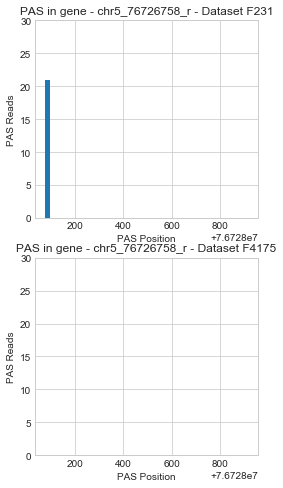

In [736]:
#plot F2 only
df = plot_F2_only[plot_F2_only.gene_id.str.contains('\w+chr5_76726758_r', regex=True)]
x = np.repeat(df.PAS, df.reads_in_PAS)
hist_bins = np.arange(min(x), max(x), 20)

gene_name = 'chr5_76726758_r'

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(4,8))
xfmt = ticker.ScalarFormatter()
xfmt.set_scientific(False)
ax1.hist(x, bins=hist_bins)
ax1.set_title('PAS in gene - ' + gene_name + ' - Dataset F231')
ax1.set_xlabel('PAS Position')
ax1.set_ylabel('PAS Reads')
ax1.set_ylim(0,30)

ax2.hist([], bins=hist_bins)
ax2.set_title('PAS in gene - ' + gene_name + ' - Dataset F4175')
ax2.set_xlabel('PAS Position')
ax2.set_ylabel('PAS Reads')
ax2.set_ylim(0,30)
                                     
plt.show();

_* plot shows PAS only present in F231 but not in F4175_

##### plot histogram of gene "chr5_148361713_r" PAS reads. Present only in F4175.


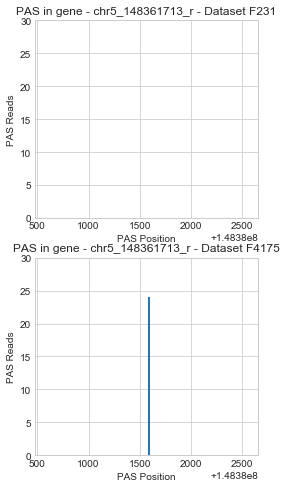

In [735]:
#plot F4 only
df = plot_F4_only[plot_F4_only.gene_id.str.contains('\w+chr5_148361713_r', regex=True)]
x = np.repeat(df.PAS, df.reads_in_PAS)
hist_bins = np.arange(min(x)-1000, max(x)+1000, 20)

gene_name = 'chr5_148361713_r'

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(4,8))
xfmt = ticker.ScalarFormatter()
xfmt.set_scientific(False)
ax1.hist([], bins=hist_bins)
ax1.set_title('PAS in gene - ' + gene_name + ' - Dataset F231')
ax1.set_xlabel('PAS Position')
ax1.set_ylabel('PAS Reads')
ax1.set_ylim(0,30)

ax2.hist(x, bins=hist_bins)
ax2.set_title('PAS in gene - ' + gene_name + ' - Dataset F4175')
ax2.set_xlabel('PAS Position')
ax2.set_ylabel('PAS Reads')
ax2.set_ylim(0,30)
                                     
plt.show();

_* plot shows PAS only present in F231 but not in F4175_

   ##### Plot histogram of gene "chr5_106712590_r", present in both dataset.

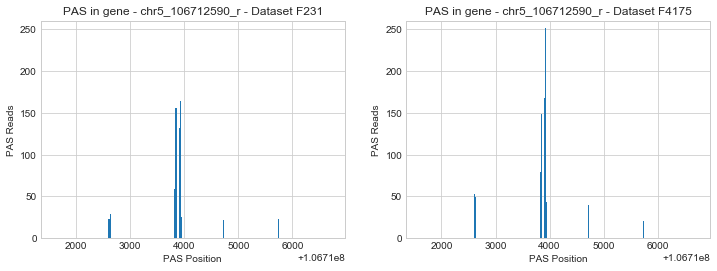

In [733]:
#plot F4 only
df = joined_PAS[joined_PAS.gene_id.str.contains('\w+chr5_106712590_r', regex=True)]
x1 = np.repeat(df.PAS, df.reads_in_PAS_x)
x2 = np.repeat(df.PAS, df.reads_in_PAS_y)
hist_bins = np.arange(min(x1)-1000, max(x1)+1000, 20)

gene_name = 'chr5_106712590_r'

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
xfmt = ticker.ScalarFormatter()
xfmt.set_scientific(False)
ax1.hist(x1, bins=hist_bins)
ax1.set_title('PAS in gene - ' + gene_name + ' - Dataset F231')
ax1.set_xlabel('PAS Position')
ax1.set_ylabel('PAS Reads')
ax1.set_ylim(bottom=0, top=260)
#ax1.set_xticklabels([])
#ax1.axes.get_xaxis()

ax2.hist(x2, bins=hist_bins)
ax2.set_title('PAS in gene - ' + gene_name + ' - Dataset F4175')
ax2.set_xlabel('PAS Position')
ax2.set_ylabel('PAS Reads')
ax2.set_ylim(bottom=0, top=260)
                                     
plt.show();

_* plot shows PAS present in both. However, notice reads at same PAS sites are different in two dataset. And a few PAS sites in the middle are not at the same loci._

---

### [Link to analysis slides](https://docs.google.com/presentation/d/1ToNBHX_-FrN8eddU1CB3elGlAIluat2g4DuuQOiEDTQ/edit?usp=sharing)